In [72]:
import numpy as np
from sklearn import datasets
from sklearn import model_selection
from sklearn.datasets import load_iris
from sklearn import linear_model
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from matplotlib.colors import ListedColormap

In [57]:
# Загрузим игрушечный датасет из sklearn
X, y = load_iris(return_X_y=True)


In [58]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

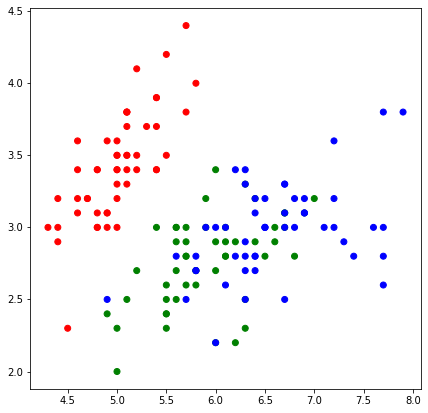

In [59]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)

Построим модель классификации на основе Стохастического градиентного спуска

In [73]:
model = linear_model.SGDClassifier(alpha=0.001, max_iter=100, random_state = 0)
model.fit(X_train, y_train)
model_predictions = model.predict(X_test)
print (metrics.accuracy_score(y_test, model_predictions))
print (metrics.classification_report(y_test, model_predictions))

0.8666666666666667
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.76      1.00      0.87        13
           2       1.00      0.33      0.50         6

    accuracy                           0.87        30
   macro avg       0.92      0.78      0.79        30
weighted avg       0.90      0.87      0.84        30



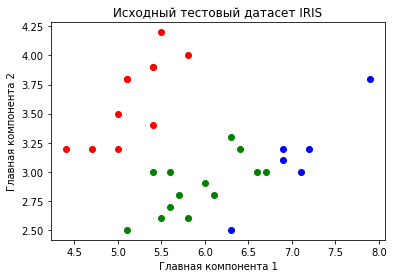

In [74]:
plt.figure()
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(X_test[y_test==i, 0], X_test[y_test==i, 1], c=c)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('Исходный тестовый датасет IRIS')
plt.show()

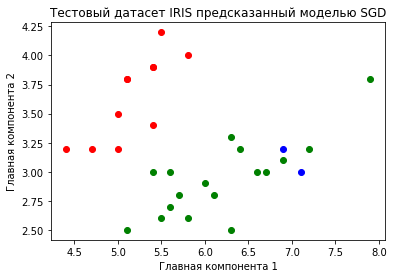

In [76]:
plt.figure()
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(X_test[model_predictions==i, 0], X_test[model_predictions==i, 1], c=c)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('Тестовый датасет IRIS предсказанный моделью SGD')
plt.show()

Применение PCA

In [77]:
# Для начала отмасштабируем выборку
X_ = X.astype(float)

rows, cols = X_.shape

# центрирование - вычитание из каждого значения среднего по строке
means = X_.mean(0)
for i in range(rows):
    for j in range(cols):
        X_[i, j] -= means[j]

# деление каждого значения на стандартное отклонение
std = np.std(X_, axis=0)
for i in range(cols):
    for j in range(rows):
        X_[j][i] /= std[i]

In [78]:
# Найдем собственные векторы и собственные значения (англ. Eigenvalues)
 
covariance_matrix = X_.T.dot(X_)

eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

print('Собственные значения в порядке убывания:')
for i in eig_pairs:
    print(i)

Собственные значения в порядке убывания:
(437.77467247979894, array([ 0.52106591, -0.26934744,  0.5804131 ,  0.56485654]))
(137.10457072021055, array([-0.37741762, -0.92329566, -0.02449161, -0.06694199]))
(22.0135313356972, array([-0.71956635,  0.24438178,  0.14212637,  0.63427274]))
(3.1072254642928967, array([ 0.26128628, -0.12350962, -0.80144925,  0.52359713]))


In [79]:
eig_sum = sum(eig_values)
var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(f'Доля дисперсии, описываемая каждой из компонент \n{var_exp}')

# а теперя оценим кумулятивную (то есть накапливаемую) дисперсию при учитывании каждой из компонент
print(f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}')

Доля дисперсии, описываемая каждой из компонент 
[72.96244541329987, 22.850761786701774, 3.6689218892828688, 0.5178709107154832]
Кумулятивная доля дисперсии по компонентам 
[ 72.96244541  95.8132072   99.48212909 100.        ]


In [80]:
# Сформируем вектор весов из собственных векторов, соответствующих первым двум главным компонентам
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))

print(f'Матрица весов W:\n', W)

Матрица весов W:
 [[ 0.52106591 -0.37741762]
 [-0.26934744 -0.92329566]
 [ 0.5804131  -0.02449161]
 [ 0.56485654 -0.06694199]]


In [81]:
# Сформируем новую матрицу "объекты-признаки"
Z = X_.dot(W)

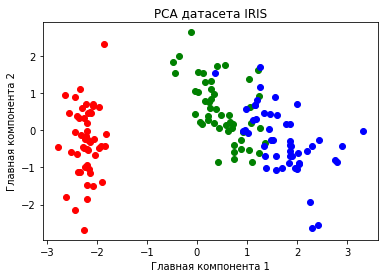

In [82]:
plt.figure()
y = iris.target
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(Z[y==i, 0], Z[y==i, 1], c=c)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('PCA датасета IRIS')
plt.show()

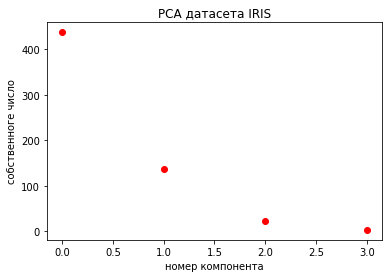

In [83]:
plt.figure()
for i,e in enumerate(eig_pairs):
    plt.plot(i,e[0],'ro') 
plt.xlabel('номер компонента')
plt.ylabel('собственноге число')
plt.title('PCA датасета IRIS')
plt.show()

PCA наиболее хорошо работает, когда собственные значения $\lambda$ на каком-то участке графика распределения убывают скачкообразно (критерий крутого склона), другими словами, если существуют предпосылки к тому, что следует решать задачу в пространстве меньшей размерности. Если же они убывают монотонно, следует рассмотреть вариант использования других методов работы с пространством признаков.


На последнем графике убывание монотонно => PCA работает не самым лучшим образом и следует применить другие методы работы с пространством признаков.